## Implementation with FLOWER

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import flwr as fl
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

In [99]:
plt.rcParams["figure.figsize"] = (25,15)

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [5]:
path="/Users/daniel.bustillo/Documents/thesis"

os.chdir(path)

In [12]:
homes= pd.read_csv("homes.csv", infer_datetime_format=True, index_col=0)

In [42]:
energy= homes['total_a']
energy= energy.dropna()
energy = energy.values
energy= energy.reshape(len(energy),1)

In [44]:
# Data partitining 
train_size  = int(len(energy) * 0.80)
test_size   = len(energy) - train_size
train, test = energy[:train_size], energy[train_size:]

In [45]:
# Scaling the data to the interval [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [46]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [51]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [75]:
timesteps = 13 # parameter to tune, timesteps

# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
X_train.shape

(14078, 13, 1)

In [84]:
model = Sequential()
model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [85]:
# Training
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.3, verbose=1)
model.summary()

Epoch 1/100
308/308 [==============================] - 4s 7ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2/100
308/308 [==============================] - 2s 7ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 3/100
308/308 [==============================] - 2s 6ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 4/100
308/308 [==============================] - 2s 6ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 5/100
308/308 [==============================] - 2s 6ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 6/100
308/308 [==============================] - 2s 7ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 7/100
308/308 [==============================] - 2s 6ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 8/100
308/308 [==============================] - 2s 7ms/step - 

In [109]:
pred_train ={}
pred_test = {}

pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

pred_train["simple_lstm"] = scaler.inverse_transform(
                              model.predict(X_train,verbose=0)).flatten()

pred_test['simple_lstm'] = scaler.inverse_transform(model.predict(X_test)).flatten()

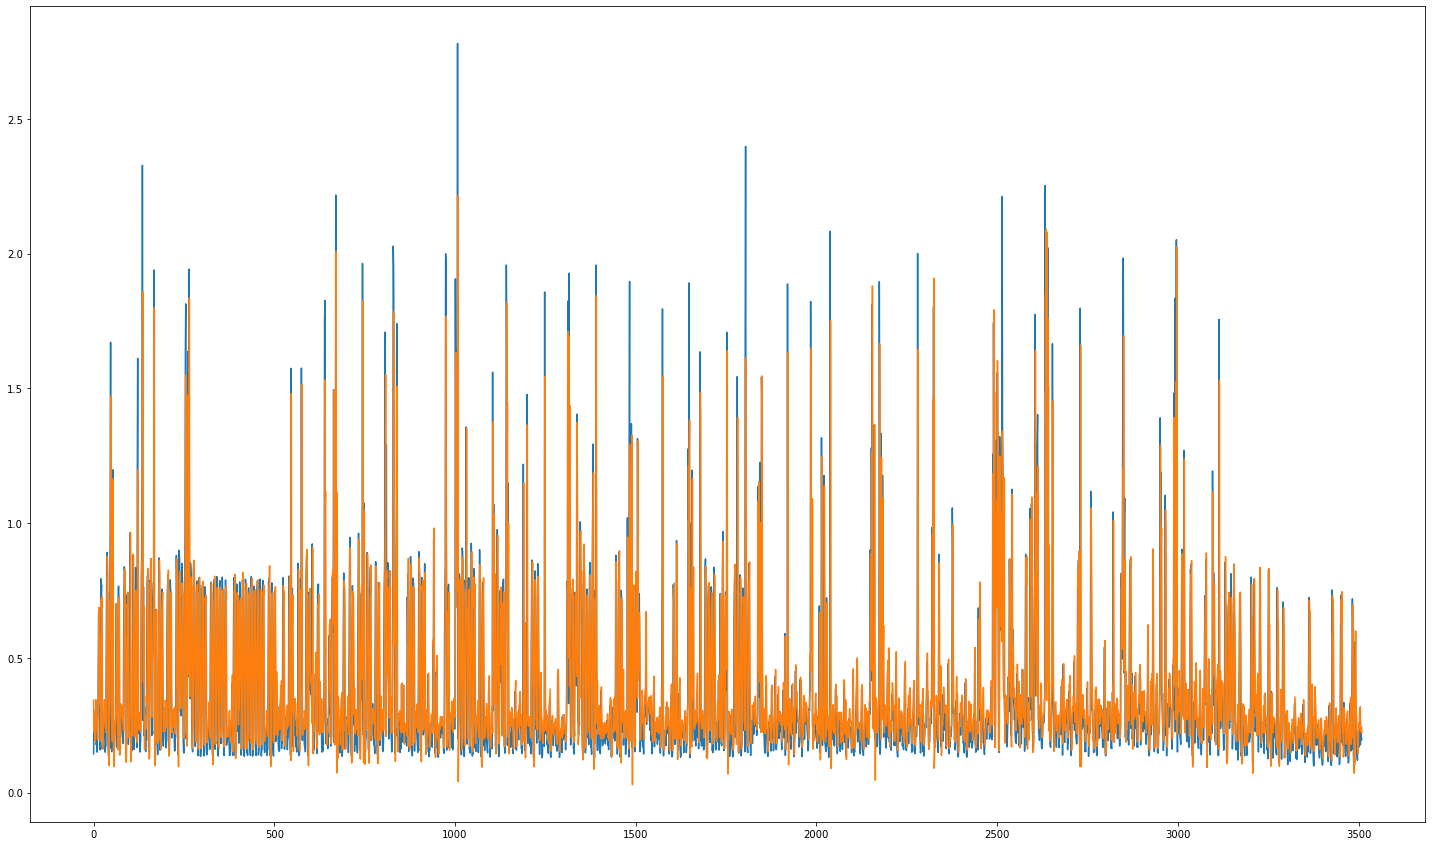

In [110]:
#plt.plot(pred_train['simple_lstm'])
plt.plot(pred_test['true'])
plt.plot(pred_test['simple_lstm'])
plt.show()


In [111]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

In [112]:
rmse_train={}
rmse_test={}

In [113]:
rmse_train["naive"] = rmse(pred_train["true"], pred_train["simple_lstm"])
rmse_test["naive"]  = rmse(pred_test["true"],  pred_test["simple_lstm"])

In [116]:
rmse_train

{'naive': 0.23744251099251615}

In [143]:
def prepare_task(home, prop=0.8):

    home= home.dropna()
    home = home.values
    home= home.reshape(len(home),1)
    return home

    # # Data partitining 
    # train_size  = int(len(home) * prop)
    # test_size   = len(home) - train_size
    # train, test = energy[:train_size], energy[train_size:]



    # # The LSTM input layer must be 3D
    # # Create the dataset with rolling window for the training set and test set
    # X_train, y_train  = create_dataset(train, timesteps)  # lookback
    # X_test, y_test    = create_dataset(test, timesteps)

In [146]:
energy1= homes['total_a']
energy1= prepare_task(energy1)

In [149]:
train, test = train_test_split(energy1, train_size=0.8, shuffle=False)

In [156]:
def scale(train, test):

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    return train, test

In [157]:
train, test = scale(train, test)

In [163]:
timesteps= 13
# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)

In [168]:
stateless_multilayer = Sequential()
stateless_multilayer.add(LSTM(7, return_sequences=True))
stateless_multilayer.add(Dropout(0.2))  # you can also add dropout layers if you like
stateless_multilayer.add(LSTM(7, return_sequences=False))
stateless_multilayer.add(Dropout(0.2))
stateless_multilayer.add(Dense(1))
stateless_multilayer.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [169]:
stateless_multilayer.fit(X_train, y_train, batch_size=32,epochs=30, validation_split=0.3 )

Epoch 1/30
308/308 [==============================] - 10s 15ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 2/30
308/308 [==============================] - 3s 11ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3/30
308/308 [==============================] - 4s 13ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 4/30
308/308 [==============================] - 4s 13ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 5/30
308/308 [==============================] - 4s 13ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 6/30
308/308 [==============================] - 4s 12ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 7/30
308/308 [==============================] - 4s 12ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 8/30
308/308 [==============================] - 4s 12ms/step -

In [170]:
pred_train["multilayer"] = scaler.inverse_transform(
                              stateless_multilayer.predict(X_train,verbose=0)).flatten()

pred_test['multilayer'] = scaler.inverse_transform(stateless_multilayer.predict(X_test)).flatten()

<AxesSubplot:>

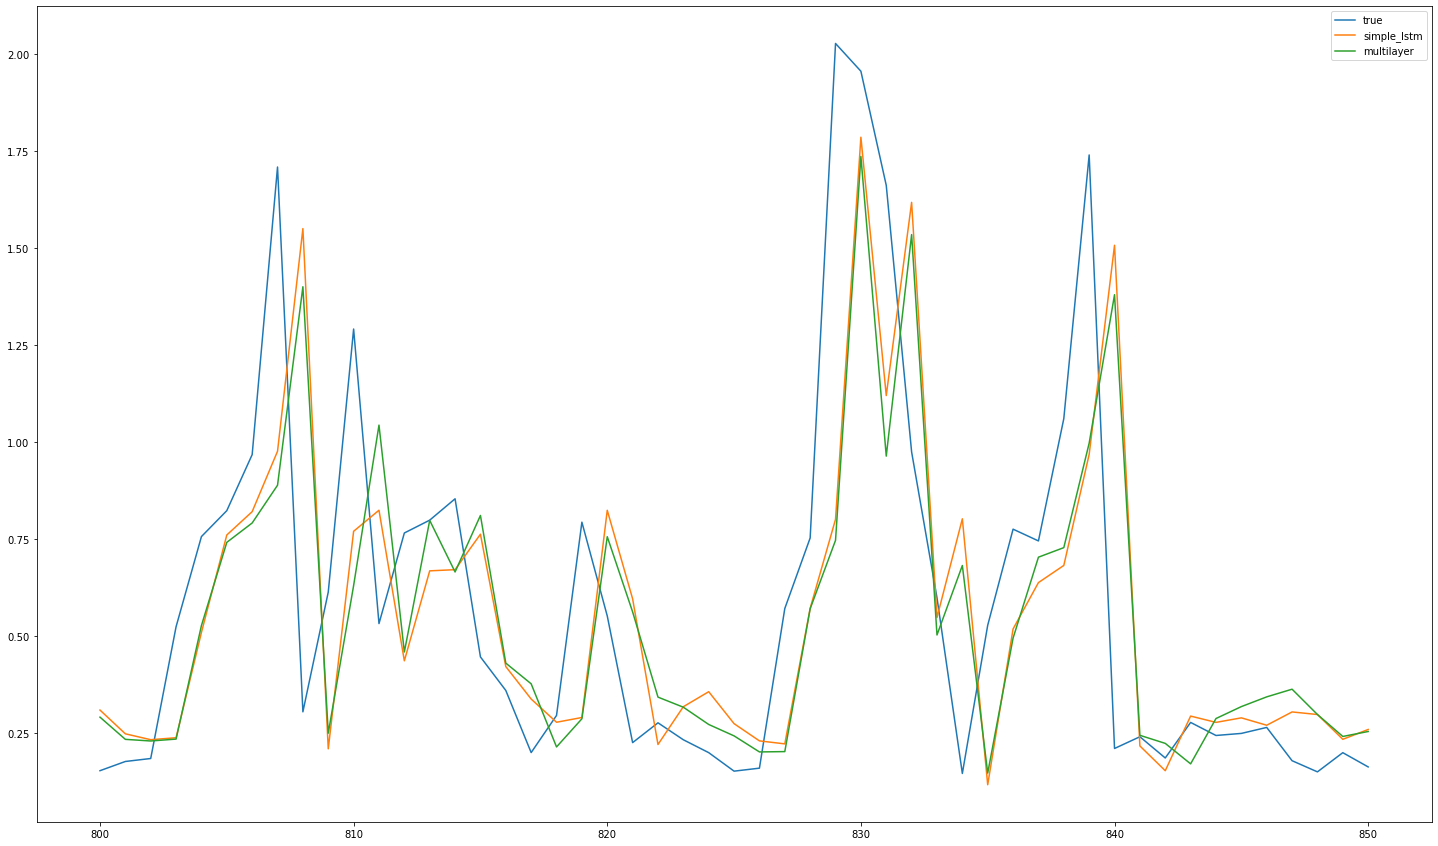

In [174]:
pd.DataFrame(pred_test).loc[800:850,].plot()